# Case Study Feature Engineering

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('csv/data.csv', delimiter=',') 
y = np.loadtxt('csv/labels.csv', delimiter=',')
with open('csv/feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

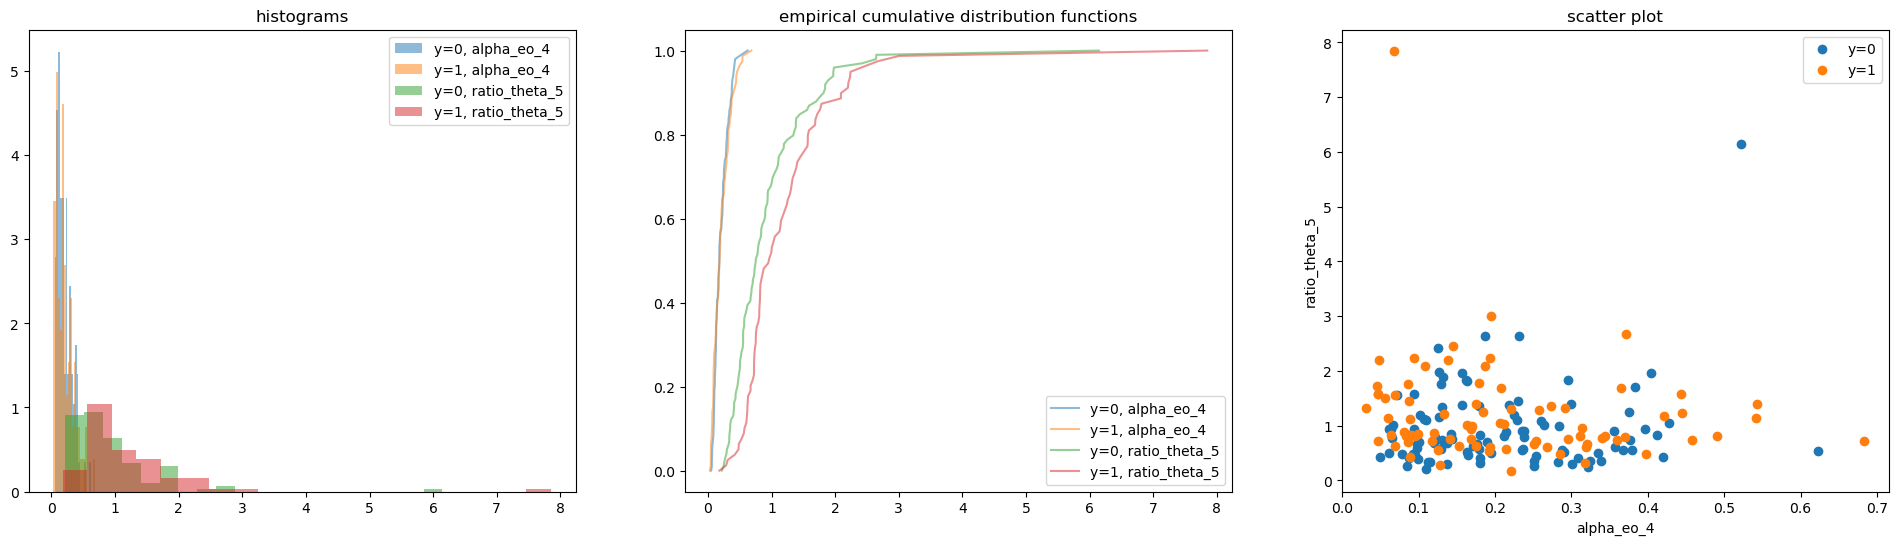

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

In [4]:
import pandas as pd

# File paths
data_file = 'csv/data.csv'
feature_names_file = 'csv/feature_names.csv'
labels_file = 'csv/labels.csv'

# Load the datasets
data = pd.read_csv(data_file, header=None)
feature_names = pd.read_csv(feature_names_file, header=None)
labels = pd.read_csv(labels_file, header=None)

# Display the first few rows of each dataset to understand their structure
data_head = data.head()
feature_names_head = feature_names.head()
labels_head = labels.head()

data_head, feature_names_head, labels_head

(       0        1        2        3        4        5        6        7    \
 0  0.11184  0.12387  0.12858  0.11324  0.10571  0.10690  0.10756  0.11064   
 1  0.29834  0.26881  0.26239  0.38009  0.34358  0.28500  0.24791  0.25033   
 2  0.36912  0.39587  0.38999  0.25772  0.40554  0.44199  0.44004  0.39947   
 3  0.76120  0.77726  0.77042  0.60161  0.70183  0.72725  0.76245  0.78904   
 4  0.16770  0.15146  0.14714  0.15728  0.14965  0.14154  0.13228  0.12760   
 
        8        9    ...      422      423      424      425      426  \
 0  0.10875  0.15893  ...  0.57161  0.73870  0.58709  0.55198  0.54811   
 1  0.26047  0.26016  ...  0.35142  0.32788  0.43164  0.49603  0.40680   
 2  0.31546  0.28348  ...  0.61924  0.86506  1.09310  0.31759  0.36353   
 3  0.72984  0.52236  ...  0.23456  0.25090  0.43196  0.71301  0.53340   
 4  0.14351  0.17252  ...  1.82160  1.73190  1.24420  2.76220  3.00930   
 
        427      428      429      430      431  
 0  0.57869  0.59345  0.60436  0.5

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# File paths
data_file = 'csv/data.csv'
labels_file = 'csv/labels.csv'

# Reload the datasets
data = pd.read_csv(data_file, header=None)
labels = pd.read_csv(labels_file, header=None)

# Data Scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame for easier handling in later steps
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Display the first few rows of the scaled data
data_scaled_df_head = data_scaled_df.head()
data_scaled_df_head, len(data_scaled_df)
#data_scaled_df

# Save the scaled data to a CSV file
#data_scaled_df.to_csv('csv/data_scaled.csv', index=False)

(        0         1         2         3         4         5         6    \
 0 -1.376627 -1.355841 -1.360565 -1.282122 -1.363906 -1.363955 -1.378199   
 1 -0.497158 -0.659425 -0.700764  0.010004 -0.137413 -0.415607 -0.622363   
 2 -0.163383 -0.048920 -0.071584 -0.582529  0.182062  0.420333  0.412327   
 3  1.685531  1.783604  1.804268  1.082636  1.709777  1.939286  2.148622   
 4 -1.113211 -1.223275 -1.269047 -1.068874 -1.137345 -1.179503 -1.245073   
 
         7         8         9    ...       422       423       424       425  \
 0 -1.389515 -1.426743 -1.157623  ... -0.571508 -0.356933 -0.536192 -0.556666   
 1 -0.638454 -0.619863 -0.637086  ... -0.865352 -0.880993 -0.744585 -0.629078   
 2  0.163416 -0.327414 -0.517172  ... -0.507945 -0.195742  0.142157 -0.860019   
 3  2.257987  1.876349  0.711178  ... -1.021302 -0.979193 -0.744156 -0.348257   
 4 -1.298327 -1.241881 -1.087742  ...  1.096609  0.910039  0.344719  2.303849   
 
         426       427       428       429       430  

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Feature Selection using Filter Method (SelectKBest with mutual information)
k = 100  # Number of features to select
select_k_best = SelectKBest(mutual_info_classif, k=k)
data_selected = select_k_best.fit_transform(data_scaled_df, labels.values.ravel())

# Convert the selected data back to a DataFrame for easier handling in later steps
selected_features = data_scaled_df.columns[select_k_best.get_support()]
data_selected_df = pd.DataFrame(data_selected, columns=selected_features)

# Display the first few rows of the data with selected features
data_selected_df_head = data_selected_df.head()
data_selected_df_head, len(data_selected_df)
#data_selected_df

# Save the selected data to a CSV file
#data_selected_df.to_csv('csv/data_selected.csv', index=False)

(        3         9         10        13        17        21        23   \
 0 -1.282122 -1.157623 -1.442808 -1.384686 -1.291956 -1.395789 -1.306044   
 1  0.010004 -0.637086  0.297024 -0.516496  0.036352 -0.115776 -0.370996   
 2 -0.582529 -0.517172  0.149837 -0.023925  0.483514  0.278146  0.351963   
 3  1.082636  0.711178  1.357448  2.160382  0.566587  0.994901  0.139309   
 4 -1.068874 -1.087742 -1.264447 -0.947825 -1.090461 -0.513482 -0.806732   
 
         25        31        37   ...       372       373       374       377  \
 0 -1.221520 -1.316433 -1.199646  ...  1.181209  0.264553 -0.280867 -0.164221   
 1  0.225838  0.154397 -0.087897  ...  0.398506  0.365921  0.329178  1.394260   
 2  0.453726  0.756902 -0.375331  ...  0.031847 -0.487606 -0.741866 -0.675333   
 3  0.945642 -0.420518  1.256854  ... -1.290754 -1.372743 -1.321074 -1.004735   
 4 -1.114830 -0.818276 -1.189756  ... -0.120119  0.025490 -0.468988 -0.641517   
 
         378       383       416       419       420  

In [7]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Wrapper Method: Recursive Feature Elimination (RFE)
# Using Logistic Regression as the estimator
estimator = LogisticRegression(max_iter=1000)
selector = RFE(estimator, n_features_to_select=100, step=10)
selector = selector.fit(data_scaled_df, labels.values.ravel())

# Get the selected features from RFE
selected_features_rfe = data_scaled_df.columns[selector.support_]
data_selected_rfe_df = data_scaled_df[selected_features_rfe]

# Display the first few rows of the data with selected features by RFE
data_selected_rfe_df_head = data_selected_rfe_df.head()
data_selected_rfe_df_head, len(data_selected_rfe_df)
#data_selected_rfe_df

# Save the selected data to a CSV file
#data_selected_rfe_df.to_csv('csv/data_selected_rfe.csv', index=False)

(        16        21        23        28        31        39        45   \
 0 -1.365277 -1.395789 -1.306044 -1.457986 -1.316433 -1.231454 -1.441125   
 1 -0.608742 -0.115776 -0.370996 -1.009095  0.154397  0.503747  0.094706   
 2  0.210659  0.278146  0.351963 -0.856644  0.756902  0.024807  0.335669   
 3  1.286383  0.994901  0.139309  0.847209 -0.420518  0.811304  0.917814   
 4 -0.830469 -0.513482 -0.806732 -0.495959 -0.818276 -1.217444 -1.171164   
 
         53        54        59   ...       371       380       381       383  \
 0  1.345939  1.273211  1.302905  ...  0.253503 -0.106444 -0.325810  1.895824   
 1 -0.745187 -0.811576 -0.749071  ...  0.649766  2.643596  2.563505  0.739067   
 2  0.084962 -0.039321  0.231545  ... -0.001051 -0.703475 -1.011870 -0.032838   
 3 -0.813236 -0.818065 -0.770478  ... -1.153625 -0.895784 -0.338154 -1.182406   
 4 -0.688866 -0.599761 -0.756899  ...  0.006599 -1.092429 -1.384363 -0.589545   
 
         385       398       409       417       422  

In [8]:
from sklearn.linear_model import LassoCV

# Embedded Method: Lasso for feature selection
lasso = LassoCV(cv=5, max_iter=10000, random_state=0)
lasso.fit(data_scaled_df, labels.values.ravel())

# Get the selected features from Lasso (non-zero coefficients)
selected_features_lasso = data_scaled_df.columns[lasso.coef_ != 0]
data_selected_lasso_df = data_scaled_df[selected_features_lasso]

# Display the first few rows of the data with selected features by Lasso
data_selected_lasso_df_head = data_selected_lasso_df.head()
data_selected_lasso_df_head, len(selected_features_lasso)
#data_selected_lasso_df

# Save the selected data to a CSV file
#data_selected_lasso_df.to_csv('csv/data_selected_lasso.csv', index=False)

(        5         23        28        31        33        37        45   \
 0 -1.363955 -1.306044 -1.457986 -1.316433 -1.239706 -1.199646 -1.441125   
 1 -0.415607 -0.370996 -1.009095  0.154397  0.137934 -0.087897  0.094706   
 2  0.420333  0.351963 -0.856644  0.756902  0.087325 -0.375331  0.335669   
 3  1.939286  0.139309  0.847209 -0.420518  0.891742  1.256854  0.917814   
 4 -1.179503 -0.806732 -0.495959 -0.818276 -1.269954 -1.189756 -1.171164   
 
         51        59        66   ...       391       392       398       400  \
 0  2.230201  1.302905  1.380048  ... -0.448798 -0.334293  0.488093  0.249414   
 1 -0.408895 -0.749071 -0.520822  ... -0.835606 -0.669301 -0.727764 -0.453114   
 2  1.161125  0.231545  0.920136  ... -0.858748 -0.739436 -0.980269 -0.818074   
 3 -0.625966 -0.770478 -0.933275  ... -0.695307 -0.207258 -0.506591 -0.812105   
 4 -0.707602 -0.756899 -0.746691  ...  1.622150  1.058533  1.388465  1.003830   
 
         412       417       419       420       422  

In [9]:
data.shape, data_selected_df.shape, data_selected_rfe_df.shape, data_selected_lasso_df.shape, labels.shape

((180, 432), (180, 100), (180, 100), (180, 82), (180, 1))

In [10]:
labels.shape[0]

180

In [11]:
data_selected.shape

(180, 100)

# TRAINING

In [12]:
# Correcting the group definition for Leave-One-Group-Out Cross-Validation
# Assuming each subject has the same number of samples
n_samples = data_selected.shape[0]  # Total number of samples in the dataset
n_subjects = 18  # Number of subjects
samples_per_subject = n_samples // n_subjects  # Assuming equal distribution of samples

# Define groups based on the number of subjects and samples per subject
groups_corrected = np.repeat(np.arange(n_subjects), samples_per_subject)

# Verify the length of groups matches the number of samples in datasets
len(groups_corrected) == n_samples

True

In [13]:
samples_per_subject

10

In [14]:
print(groups_corrected.shape)
groups_corrected

(180,)


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17])

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
import numpy as np

# Defining Leave-One-Group-Out Cross-Validation
logo = LeaveOneGroupOut()

# Preparing the groups for cross-validation (assuming each 10 samples belong to one subject)
groups = np.repeat(np.arange(labels.shape[0] / 10), 10)

# SVM Classifier - GridSearch for Hyperparameter Tuning
# Defining a range of C values for tuning
parameters = {'C': [0.1, 1, 10, 100]}

# Training SVM on the dataset from the Filter Method (Mutual Information)
svm_classifier = SVC(kernel='rbf', random_state=0)
svm_grid_search = GridSearchCV(svm_classifier, parameters, cv=logo, scoring='accuracy')
svm_grid_search.fit(data_selected_df, labels.values.ravel(), groups=groups)

# Best parameters and score from the grid search
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

svm_best_params, svm_best_score

({'C': 10}, 0.9277777777777777)

In [17]:
# Training SVM on the dataset from the Wrapper Method (RFE)
svm_classifier = SVC(kernel='rbf', random_state=0)
svm_grid_search = GridSearchCV(svm_classifier, parameters, cv=logo, scoring='accuracy')
svm_grid_search.fit(data_selected_rfe_df, labels.values.ravel(), groups=groups_corrected)

# Best parameters and score from the grid search
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

svm_best_params, svm_best_score

({'C': 10}, 0.9500000000000001)

In [18]:
# Training SVM on the dataset from the Embedded Method (Lasso)
svm_classifier = SVC(kernel='rbf', random_state=0)
svm_grid_search = GridSearchCV(svm_classifier, parameters, cv=logo, scoring='accuracy')
svm_grid_search.fit(data_selected_lasso_df, labels.values.ravel(), groups=groups_corrected)

# Best parameters and score from the grid search
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

svm_best_params, svm_best_score

({'C': 10}, 0.9611111111111109)

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
import numpy as np

# Initialize the SVM classifier with RBF kernel
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale')

# Initialize Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# We will need to know the group for each sample (which subject it belongs to)
# Assuming the data is ordered by subject and each subject has the same number of samples
n_samples_per_subject = int(len(data) / 18)  # 18 subjects
groups = np.repeat(range(18), n_samples_per_subject)

# Prepare datasets for training
datasets = {
    'Filter Method (MI)': data_selected_df,
    'Wrapper Method (RFE)': data_selected_rfe_df,
    'Embedded Method (Lasso)': data_selected_lasso_df
}

# Function to evaluate model using Leave-One-Group-Out Cross-Validation
def evaluate_model(model, X, y, groups):
    scores = cross_val_score(model, X, y.values.ravel(), groups=groups, cv=logo, scoring='accuracy')
    return np.mean(scores), np.std(scores)

# Evaluate SVM on each dataset
svm_results = {method: evaluate_model(svm_clf, dataset, labels, groups) for method, dataset in datasets.items()}
svm_results

{'Filter Method (MI)': (0.8666666666666667, 0.09428090415820635),
 'Wrapper Method (RFE)': (0.9388888888888888, 0.06781419786518722),
 'Embedded Method (Lasso)': (0.922222222222222, 0.06285393610547087)}